# COGS 108 - EDA Checkpoint

# Names

- Issac Navarro
- Kelly Nham
- Aryan Safari
- Albert Zhong

<a id='research_question'></a>
# Research Question

Do Criminal activities have a correlation with murder rates of an Area. If so, which criminal activities affect it the most.

# Setup

In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import patsy
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

# Data Cleaning

The raw data requires a hefty amount of wrangling due to the fact that the raw data is incredibly untidy (as seen in the first cell below). For starters, the Metropolitan Statistical Area (MSA) is always listed on one line with the next few lines being NaNs since it was made for humans to see and understand that the NaNs were meant to still correspond to the previously listed MSA. To further throw a wrench in things, many of the lines following each MSA aren't even data, such as the line after each one that says which counties are included in the MSA. Next, the columns are basically all unnamed because the actual names for them are all in row 2 (and overall rows 0-2 are basically just gibberish). Furthermore, they list the murders for each city in the MSA, but only list the rate per 100k inhabitants for the whole MSA. Finally, there were many different crimes listed but the one we are focusing on are murder rates. Thus, to wrangle all the data for each year, I had to drop many of the columns and rows, so that it is only the murder rates per city and per 100k inhabitants in each MSA, as well as the population of each city and MSA. To finish up the wrangling, I split up each year into two datasets: one for each city's murders and one for each MSA's murder rate per 100k inhabitants.

In [25]:
untidyShowcase = pd.read_csv('https://raw.githubusercontent.com/azhong19/COGS108_Repo/main/2015.xls%20-%2015tbl06.csv')
untidyShowcase.iloc[0:15]

,Table 6,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Crime in the United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"by Metropolitan Statistical Area, 2015",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Metropolitan Statistical Area,Counties/principal cities,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape1,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft
3,"Abilene, TX M.S.A.",NaN,"169,713",,NaN,NaN,NaN,NaN,,NaN,NaN,NaN
4,NaN,"Includes Callahan, Jones, and Taylor Counties",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,City of Abilene,"121,764",613,7,84,128,394,"5,354","1,168","3,798",388
6,NaN,Total area actually reporting,100.0%,700,9,95,133,463,"6,125","1,446","4,232",447
7,NaN,"Rate per 100,000 inhabitants",NaN,412.5,5.3,56.0,78.4,272.8,"3,609.0",852.0,"2,493.6",263.4
8,"Akron, OH M.S.A.",NaN,"704,320",,NaN,NaN,NaN,NaN,,NaN,NaN,NaN
9,NaN,Includes Portage and Summit Counties,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#initial csv reading and wrangling (2015)
df2015 = pd.read_csv('https://raw.githubusercontent.com/azhong19/COGS108_Repo/main/2015.xls%20-%2015tbl06.csv')
df2015 = df2015.drop(df2015.columns[[3]], axis = 1)
df2015.columns = ['Area', 'City', 'Population', 'Murders', 'Rape', 'Robbery', 'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft','Motor_Vehicle_Theft']
df2015 = df2015[(df2015['City'].str.contains("City of")) | (df2015['City'].str.contains("Rate per")) | (df2015['Area'].str.contains("M.S.A")) | (df2015['Area'].str.contains("M.D"))]
df2015 = df2015.reset_index(drop=True)

#creating a joined dataset for Metropolitan Statistical Area and Murders per 100k inhabitants
area2015 = df2015[['Area', 'Population']]
area2015 = area2015.dropna().reset_index(drop=True)
rate2015 = df2015[['City', 'Murders']]
rate2015 = rate2015[(rate2015['City'].str.contains("Rate per")) | (rate2015['City'].str.contains("Rate per"))] #for some reason I have to have the or statement here or it doesn't work, I know it looks incredibly jank but I couldn't think of a better way to do it
rate2015 = rate2015.reset_index(drop=True)
joined2015 = area2015.join(rate2015, lsuffix='Area', rsuffix='City')
joined2015 = joined2015.drop(joined2015.columns[[2]], axis = 1)
joined2015.columns = ['Area', 'Population', 'Rate (per 100k inhabitants)']

#creating a dataset for murders per city
city2015 = df2015[['City', 'Population', 'Murders', 'Rape', 'Robbery', 'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft' ]]
city2015 = city2015[(city2015['City'].str.contains("City of")) | (city2015['City'].str.contains("City of"))] #again have to have the or statement here, this is gonna make me lose what little sanity I had left
city2015 = city2015.reset_index(drop=True)
city2015
#joined2015

,City,Population,Murders,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft
0,City of Abilene,"121,764",7,84,128,394,"5,354","1,168","3,798",388
1,City of Akron,"197,587",28,166,402,572,"8,027","2,426","5,002",599
2,City of Albany,"75,357",10,35,201,554,"3,902","1,137","2,616",149
3,City of Albany,"52,394",2,10,16,13,"1,726",173,"1,447",106
4,City of Albuquerque,"559,721",43,404,"1,686","3,273","33,993","5,996","22,818","5,179"
...,...,...,...,...,...,...,...,...,...,...
556,City of Yakima,"93,798",7,51,126,330,"5,091","1,307","3,110",674
557,City of York,"43,864",10,19,178,118,"1,399",336,939,124
558,City of Hanover,"15,494",0,3,6,15,453,27,419,7
559,City of Yuba City,"65,974",0,28,66,122,"1,792",429,"1,160",203


In [27]:
#initial csv reading and wrangling (2016)
df2016 = pd.read_csv('https://raw.githubusercontent.com/azhong19/COGS108_Repo/main/2016.xls%20-%2016tbl04.csv')
df2016 = df2016.drop(df2016.columns[[3]], axis = 1)
df2016.columns = ['Area', 'City', 'Population', 'Murders', 'Rape', 'Robbery', 'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft','Motor_Vehicle_Theft']
df2016 = df2016[(df2016['City'].str.contains("City of")) | (df2016['City'].str.contains("Rate per")) | (df2016['Area'].str.contains("M.S.A")) | (df2016['Area'].str.contains("M.D"))]
df2016 = df2016.reset_index(drop=True)

#creating a joined dataset for Metropolitan Statistical Area and Murders per 100k inhabitants
area2016 = df2016[['Area', 'Population']]
area2016 = area2016.dropna().reset_index(drop=True)
rate2016 = df2016[['City', 'Murders']]
rate2016 = rate2016[(rate2016['City'].str.contains("Rate per")) | (rate2016['City'].str.contains("Rate per"))] #for some reason I have to have the or statement here or it doesn't work, I know it looks incredibly jank but I couldn't think of a better way to do it
rate2016 = rate2016.reset_index(drop=True)
joined2016 = area2016.join(rate2016, lsuffix='Area', rsuffix='City')
joined2016 = joined2016.drop(joined2016.columns[[2]], axis = 1)
joined2016.columns = ['Area', 'Population', 'Rate (per 100k inhabitants)']

#creating a dataset for murders per city
city2016 = df2016[['City', 'Population', 'Murders', 'Rape', 'Robbery', 'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft' ]]
city2016 = city2016[(city2016['City'].str.contains("City of")) | (city2016['City'].str.contains("City of"))] #again have to have the or statement here, this is gonna make me lose what little sanity I had left
city2016 = city2016.reset_index(drop=True)
city2016

,City,Population,Murders,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft
0,City of Abilene,"122,523",8,70,133,335,"4,269",905,"3,113",251
1,City of Akron,"197,257",34,212,415,555,"8,646","2,483","5,483",680
2,City of Albany,"74,330",16,28,204,625,"3,620",888,"2,585",147
3,City of Albany,"52,544",0,12,21,10,"1,512",146,"1,256",110
4,City of Albany,"98,617",2,59,250,537,"3,461",491,"2,858",112
...,...,...,...,...,...,...,...,...,...,...
568,"City of Worcester, MA","184,595",8,63,394,"1,177","5,358","1,366","3,473",519
569,City of Yakima,"94,111",13,47,126,310,"4,943","1,143","3,163",637
570,City of York,"44,017",8,12,208,188,"1,408",298,917,193
571,City of Hanover,"15,537",0,0,9,14,418,43,371,4


In [28]:
#initial csv reading and wrangling (2017)
df2017 = pd.read_csv('https://raw.githubusercontent.com/azhong19/COGS108_Repo/main/2017%20crime.csv')
df2017 = df2017.drop(df2017.columns[[3]], axis = 1)
df2017.columns = ['Area', 'City', 'Population', 'Murders', 'Rape', 'Robbery', 'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft','Motor_Vehicle_Theft']
df2017 = df2017[(df2017['City'].str.contains("City of")) | (df2017['City'].str.contains("Rate per")) | (df2017['Area'].str.contains("M.S.A")) | (df2017['Area'].str.contains("M.D"))]
df2017 = df2017.reset_index(drop=True)

#creating a joined dataset for Metropolitan Statistical Area and Murders per 100k inhabitants
area2017 = df2017[['Area', 'Population']]
area2017 = area2017.dropna().reset_index(drop=True)
rate2017 = df2017[['City', 'Murders']]
rate2017 = rate2017[(rate2017['City'].str.contains("Rate per")) | (rate2017['City'].str.contains("Rate per"))] #for some reason I have to have the or statement here or it doesn't work, I know it looks incredibly jank but I couldn't think of a better way to do it
rate2017 = rate2017.reset_index(drop=True)
joined2017 = area2017.join(rate2017, lsuffix='Area', rsuffix='City')
joined2017 = joined2017.drop(joined2017.columns[[2]], axis = 1)
joined2017.columns = ['Area', 'Population', 'Rate (per 100k inhabitants)']

#creating a dataset for murders per city
city2017 = df2017[['City', 'Population', 'Murders', 'Rape', 'Robbery', 'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft' ]]
city2017 = city2017[(city2017['City'].str.contains("City of")) | (city2017['City'].str.contains("City of"))] #again have to have the or statement here, this is gonna make me lose what little sanity I had left
city2017 = city2017.reset_index(drop=True)
city2017

,City,Population,Murders,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft
0,"City of Abilene2, 3","122,981",4,100,138,394,NaN,NaN,"2,605",260
1,City of Akron,"197,412",42,209,395,731,"8,360","2,301","5,304",755
2,City of Albany,"73,209",22,27,152,626,"4,116",879,"3,048",189
3,City of Albany2,"53,701",0,8,20,28,"1,406",158,"1,137",111
4,City of Albany,"98,174",8,54,247,567,"3,394",432,"2,853",109
...,...,...,...,...,...,...,...,...,...,...
591,City of Yakima,"94,375",13,70,150,360,"4,306",901,"2,841",564
592,City of York,"43,857",14,10,191,257,"1,288",251,885,152
593,City of Hanover,"15,606",0,2,10,24,378,32,340,6
594,City of Yuba City,"67,042",0,23,82,150,"2,207",380,"1,448",379


In [29]:
#initial csv reading and wrangling (2018)
df2018 = pd.read_csv('https://raw.githubusercontent.com/azhong19/COGS108_Repo/main/2018.xls%20-%2018tbl06.csv')
df2018 = df2018.drop(df2018.columns[[3]], axis = 1)
df2018.columns = ['Area', 'City', 'Population', 'Murders', 'Rape', 'Robbery', 'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft','Motor_Vehicle_Theft']
df2018 = df2018[(df2018['City'].str.contains("City of")) | (df2018['City'].str.contains("Rate per")) | (df2018['Area'].str.contains("M.S.A")) | (df2018['Area'].str.contains("M.D"))]
df2018 = df2018.reset_index(drop=True)

#creating a joined dataset for Metropolitan Statistical Area and Murders per 100k inhabitants
area2018 = df2018[['Area', 'Population']]
area2018 = area2018.dropna().reset_index(drop=True)
rate2018 = df2018[['City', 'Murders']]
rate2018 = rate2018[(rate2018['City'].str.contains("Rate per")) | (rate2018['City'].str.contains("Rate per"))] #for some reason I have to have the or statement here or it doesn't work, I know it looks incredibly jank but I couldn't think of a better way to do it
rate2018 = rate2018.reset_index(drop=True)
joined2018 = area2018.join(rate2018, lsuffix='Area', rsuffix='City')
joined2018 = joined2018.drop(joined2018.columns[[2]], axis = 1)
joined2018.columns = ['Area', 'Population', 'Rate (per 100k inhabitants)']

#creating a dataset for murders per city
city2018 = df2018[['City', 'Population', 'Murders', 'Rape', 'Robbery', 'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft' ]]
city2018 = city2018[(city2018['City'].str.contains("City of")) | (city2018['City'].str.contains("City of"))] #again have to have the or statement here, this is gonna make me lose what little sanity I had left
city2018 = city2018.reset_index(drop=True)
city2018

,City,Population,Murders,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft
0,City of Abilene,"122,480",8,97,104,382,"3,528",734,"2,561",233
1,City of Akron,"197,690",38,221,387,"1,058","7,159","1,740","4,701",718
2,City of Albany,"72,594",15,28,113,653,"3,704",760,"2,666",278
3,City of Albany,"98,322",12,52,209,550,"3,147",432,"2,585",130
4,City of Schenectady,"65,550",1,57,136,426,"2,106",353,"1,542",211
...,...,...,...,...,...,...,...,...,...,...
569,City of Yakima,"93,959",16,49,121,235,"3,343",625,"2,212",506
570,City of York,"44,170",20,7,130,293,"1,137",197,710,230
571,City of Hanover,"15,653",1,2,13,33,437,30,396,11
572,City of Yuba City,"67,035",1,35,75,153,"1,846",234,"1,356",256


In [30]:
#initial csv reading and wrangling (2019)
df2019 = pd.read_csv('https://raw.githubusercontent.com/azhong19/COGS108_Repo/main/2019.xls%20-%2019tbl06.csv')
df2019 = df2019.drop(df2019.columns[[3]], axis = 1)
df2019.columns = ['Area', 'City', 'Population', 'Murders', 'Rape', 'Robbery', 'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft','Motor_Vehicle_Theft']
df2019 = df2019[(df2019['City'].str.contains("City of")) | (df2019['City'].str.contains("Rate per")) | (df2019['Area'].str.contains("M.S.A")) | (df2019['Area'].str.contains("M.D"))]
df2019 = df2019.reset_index(drop=True)

#creating a joined dataset for Metropolitan Statistical Area and Murders per 100k inhabitants
area2019 = df2019[['Area', 'Population']]
area2019 = area2019.dropna().reset_index(drop=True)
rate2019 = df2019[['City', 'Murders']]
rate2019 = rate2019[(rate2019['City'].str.contains("Rate per")) | (rate2019['City'].str.contains("Rate per"))] #for some reason I have to have the or statement here or it doesn't work, I know it looks incredibly jank but I couldn't think of a better way to do it
rate2019 = rate2019.reset_index(drop=True)
joined2019 = area2019.join(rate2018, lsuffix='Area', rsuffix='City')
joined2019 = joined2019.drop(joined2019.columns[[2]], axis = 1)
joined2019.columns = ['Area', 'Population', 'Rate (per 100k inhabitants)']

#creating a dataset for murders per city
city2019 = df2019[['City', 'Population', 'Murders', 'Rape', 'Robbery', 'Aggravated_Assault', 'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft' ]]
city2019 = city2019[(city2019['City'].str.contains("City of")) | (city2019['City'].str.contains("City of"))] #again have to have the or statement here, this is gonna make me lose what little sanity I had left
city2019 = city2019.reset_index(drop=True)
city2019

,City,Population,Murders,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft
0,City of Abilene,"123,665",6,87,68,297,"3,112",576,"2,330",206
1,City of Akron,"197,882",27,181,328,"1,246","6,568","1,686","4,305",577
2,City of Albany3,"74,989",12,32,165,581,"3,452",729,"2,489",234
3,City of Albany,"54,993",1,10,16,43,"1,467",128,"1,242",97
4,City of Lebanon,"17,304",0,11,0,18,372,22,323,27
...,...,...,...,...,...,...,...,...,...,...
490,"City of Winchester, VA","28,201",1,39,6,34,657,76,559,22
491,"City of Worcester, MA","184,945",13,40,229,883,"3,792",786,"2,637",369
492,City of Yakima,"94,168",9,44,91,276,"2,723",439,"1,866",418
493,City of Yuba City,"67,164",3,28,52,158,"1,823",230,"1,334",259


Now that the data is all wrangled we can finally clean the data. The main things that need to be done are removing the random numbers in the city/MSA names as well as changing the population be an int instead of an object.

In [31]:
#removes all numbers
def standardize_city_MSA_names(string):
    
    string = string.strip()
    string = string.replace("1", "")
    string = string.replace("2", "")
    string = string.replace("3", "")
    string = string.replace("4", "")
    string = string.replace("5", "")
    string = string.replace("6", "")
    string = string.replace("7", "")
    string = string.replace("8", "")
    string = string.replace("9", "")
    string = string.replace("0", "")
    string = string.replace(",", "")
    string = string.strip()
    
    return string

joined2015['Area'] = joined2015['Area'].apply(standardize_city_MSA_names)
city2015['City'] = city2015['City'].apply(standardize_city_MSA_names)

joined2016['Area'] = joined2016['Area'].apply(standardize_city_MSA_names)
city2016['City'] = city2016['City'].apply(standardize_city_MSA_names)

joined2017['Area'] = joined2017['Area'].apply(standardize_city_MSA_names)
city2017['City'] = city2017['City'].apply(standardize_city_MSA_names)

joined2018['Area'] = joined2018['Area'].apply(standardize_city_MSA_names)
city2018['City'] = city2018['City'].apply(standardize_city_MSA_names)

joined2019['Area'] = joined2019['Area'].apply(standardize_city_MSA_names)
city2019['City'] = city2019['City'].apply(standardize_city_MSA_names)
city2019

,City,Population,Murders,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft
0,City of Abilene,"123,665",6,87,68,297,"3,112",576,"2,330",206
1,City of Akron,"197,882",27,181,328,"1,246","6,568","1,686","4,305",577
2,City of Albany,"74,989",12,32,165,581,"3,452",729,"2,489",234
3,City of Albany,"54,993",1,10,16,43,"1,467",128,"1,242",97
4,City of Lebanon,"17,304",0,11,0,18,372,22,323,27
...,...,...,...,...,...,...,...,...,...,...
490,City of Winchester VA,"28,201",1,39,6,34,657,76,559,22
491,City of Worcester MA,"184,945",13,40,229,883,"3,792",786,"2,637",369
492,City of Yakima,"94,168",9,44,91,276,"2,723",439,"1,866",418
493,City of Yuba City,"67,164",3,28,52,158,"1,823",230,"1,334",259


In [32]:
#converts population into an int
def standardize_numbers(arr):
    string = ''
    output = []
    for i in arr:
        string = i
        if isinstance(string, str):
            string = string.strip()
            string = string.replace(",", "")
            string = string.strip()
            string = int(string)
            output.append(string)
        elif(pd.isnull(string)):
            output.append(string)
        else:
            string = int(string)
            output.append(string)
    
    return output

city2015.iloc[:,1:] = city2015.iloc[:,1:].apply(standardize_numbers)
city2016.iloc[:,1:] = city2016.iloc[:,1:].apply(standardize_numbers)
city2017.iloc[:,1:] = city2017.iloc[:,1:].apply(standardize_numbers)
city2018.iloc[:,1:] = city2018.iloc[:,1:].apply(standardize_numbers)
city2019.iloc[:,1:] = city2019.iloc[:,1:].apply(standardize_numbers)
city2015

,City,Population,Murders,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft
0,City of Abilene,121764,7,84,128,394,5354,1168,3798,388
1,City of Akron,197587,28,166,402,572,8027,2426,5002,599
2,City of Albany,75357,10,35,201,554,3902,1137,2616,149
3,City of Albany,52394,2,10,16,13,1726,173,1447,106
4,City of Albuquerque,559721,43,404,1686,3273,33993,5996,22818,5179
...,...,...,...,...,...,...,...,...,...,...
556,City of Yakima,93798,7,51,126,330,5091,1307,3110,674
557,City of York,43864,10,19,178,118,1399,336,939,124
558,City of Hanover,15494,0,3,6,15,453,27,419,7
559,City of Yuba City,65974,0,28,66,122,1792,429,1160,203


In [33]:
#combines all the murders per city dataframes into one
citycombine = city2015.join(city2016, lsuffix = ' 2015', rsuffix = ' 2016').join(city2017).join(city2018, lsuffix = ' 2017', rsuffix = ' 2018').join(city2019)
#citycombine = citycombine.drop(citycombine.columns[[3, 6, 9, 12]], axis = 1)
citycombine = citycombine.rename(columns={"City 2015": "City", "Population": "Population 2019", "Murders": "Murders 2019",'Rape':'Rape 2019', 'Robbery':'Robbery 2019', 'Aggravated_Assault': 'Aggravated_Assault 2019', 'Property_Crime':  'Property_Crime 2019', 'Burglary': 'Burglary 2019', 'Larceny_Theft': 'Larceny_Theft 2019', 'Motor_Vehicle_Theft': 'Motor_Vehicle_Theft 2019'})
citycombine = citycombine.dropna()
print(citycombine.columns)
display(citycombine)


Index(['City', 'Population 2015', 'Murders 2015', 'Rape 2015', 'Robbery 2015',
       'Aggravated_Assault 2015', 'Property_Crime 2015', 'Burglary 2015',
       'Larceny_Theft 2015', 'Motor_Vehicle_Theft 2015', 'City 2016',
       'Population 2016', 'Murders 2016', 'Rape 2016', 'Robbery 2016',
       'Aggravated_Assault 2016', 'Property_Crime 2016', 'Burglary 2016',
       'Larceny_Theft 2016', 'Motor_Vehicle_Theft 2016', 'City 2017',
       'Population 2017', 'Murders 2017', 'Rape 2017', 'Robbery 2017',
       'Aggravated_Assault 2017', 'Property_Crime 2017', 'Burglary 2017',
       'Larceny_Theft 2017', 'Motor_Vehicle_Theft 2017', 'City 2018',
       'Population 2018', 'Murders 2018', 'Rape 2018', 'Robbery 2018',
       'Aggravated_Assault 2018', 'Property_Crime 2018', 'Burglary 2018',
       'Larceny_Theft 2018', 'Motor_Vehicle_Theft 2018', 'City',
       'Population 2019', 'Murders 2019', 'Rape 2019', 'Robbery 2019',
       'Aggravated_Assault 2019', 'Property_Crime 2019', 'Burglary

,City,Population 2015,Murders 2015,Rape 2015,Robbery 2015,Aggravated_Assault 2015,Property_Crime 2015,Burglary 2015,Larceny_Theft 2015,Motor_Vehicle_Theft 2015,...,City,Population 2019,Murders 2019,Rape 2019,Robbery 2019,Aggravated_Assault 2019,Property_Crime 2019,Burglary 2019,Larceny_Theft 2019,Motor_Vehicle_Theft 2019
1,City of Akron,197587,28,166,402,572,8027,2426,5002,599,...,City of Akron,197882.0,27.0,181.0,328.0,1246.0,6568.0,1686.0,4305.0,577.0
2,City of Albany,75357,10,35,201,554,3902,1137,2616,149,...,City of Albany,74989.0,12.0,32.0,165.0,581.0,3452.0,729.0,2489.0,234.0
3,City of Albany,52394,2,10,16,13,1726,173,1447,106,...,City of Albany,54993.0,1.0,10.0,16.0,43.0,1467.0,128.0,1242.0,97.0
4,City of Albuquerque,559721,43,404,1686,3273,33993,5996,22818,5179,...,City of Lebanon,17304.0,0.0,11.0,0.0,18.0,372.0,22.0,323.0,27.0
5,City of Alexandria,48305,7,11,168,802,4046,1011,2794,241,...,City of Albany,97221.0,4.0,60.0,189.0,483.0,2919.0,445.0,2315.0,159.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,City of South Bend IN,101240,17,88,350,265,5410,1430,3612,368,...,City of Winchester VA,28201.0,1.0,39.0,6.0,34.0,657.0,76.0,559.0,22.0
491,City of Mishawaka IN,48164,2,21,45,53,2312,302,1878,132,...,City of Worcester MA,184945.0,13.0,40.0,229.0,883.0,3792.0,786.0,2637.0,369.0
492,City of Spartanburg,37707,6,26,95,253,2383,338,1916,129,...,City of Yakima,94168.0,9.0,44.0,91.0,276.0,2723.0,439.0,1866.0,418.0
493,City of Spokane,212698,12,119,333,647,15971,2817,11408,1746,...,City of Yuba City,67164.0,3.0,28.0,52.0,158.0,1823.0,230.0,1334.0,259.0


In [34]:
#combines all the datasets with Metropolitan Statistical Area and Murders per 100k inhabitants into one
joinedcombine = joined2015.join(joined2016, lsuffix = ' 2015', rsuffix = ' 2016').join(joined2017).join(joined2018, lsuffix = ' 2017', rsuffix = ' 2018').join(joined2019)
joinedcombine = joinedcombine.drop(joinedcombine.columns[[3, 6, 9, 12]], axis = 1)
joinedcombine = joinedcombine.rename(columns={"Area 2015": "Area", "Population": "Population 2019", "Rate (per 100k inhabitants)": "Rate (per 100k inhabitants) 2019"})
joinedcombine

,Area,Population 2015,Rate (per 100k inhabitants) 2015,Population 2016,Rate (per 100k inhabitants) 2016,Population 2017,Rate (per 100k inhabitants) 2017,Population 2018,Rate (per 100k inhabitants) 2018,Population 2019,Rate (per 100k inhabitants) 2019
0,Abilene TX M.S.A.,"169,713",5.3,"169,885",6.5,"170,995",4.1,"170,417",5.3,"171,125",5.3
1,Akron OH M.S.A.,"704,320",5.1,"703,561",6.0,"703,907",7.4,"704,283",6.4,"703,784",6.4
2,Albany GA M.S.A.,"154,516",7.8,"152,566",11.8,"151,534",15.2,"147,142",11.6,"149,257",11.6
3,Albany OR M.S.A.,"120,716",2.5,"122,030",0.0,"124,014",1.6,"871,741",2.2,"128,105",2.2
4,Albuquerque NM M.S.A.,"905,803",6.1,"878,166",2.0,"885,673",2.0,"915,468",9.5,"879,862",9.5
...,...,...,...,...,...,...,...,...,...,...,...
373,Guayama Puerto Rico M.S.A.,"79,086",11.4,"282,695",6.0,"135,895",2.9,NaN,NaN,NaN,NaN
374,Mayaguez Puerto Rico M.S.A.,"95,988",11.5,"134,144",5.2,"118,293",3.4,NaN,NaN,NaN,NaN
375,Ponce Puerto Rico M.S.A.,"317,185",18.0,"861,261",1.4,"119,117",1.7,NaN,NaN,NaN,NaN
376,San German Puerto Rico M.S.A.,"130,228",5.4,"250,717",8.4,"141,891",3.5,NaN,NaN,NaN,NaN


In [35]:
#sets up dataframe to create lineplot

years = ['2015', '2016', '2017', '2018', '2019']
rates_df = joinedcombine[['Area','Rate (per 100k inhabitants) 2015', 'Rate (per 100k inhabitants) 2016', 'Rate (per 100k inhabitants) 2017', 'Rate (per 100k inhabitants) 2018', 'Rate (per 100k inhabitants) 2019']]
rates_df2 = rates_df.dropna().reset_index(drop=True)
rates_df2 = rates_df2.rename (columns = {'Rate (per 100k inhabitants) 2015': 'Rate 2015', 'Rate (per 100k inhabitants) 2016': 'Rate 2016', 'Rate (per 100k inhabitants) 2017': 'Rate 2017', 'Rate (per 100k inhabitants) 2018': 'Rate 2018', 'Rate (per 100k inhabitants) 2019': 'Rate 2019'})
rates_df2 = rates_df2.set_index('Area')
rates_df3 = rates_df2.transpose()
rates_df3 = rates_df3.apply(pd.to_numeric)
rates_df3['Years'] = years
rates_df3

Area,Abilene TX M.S.A.,Akron OH M.S.A.,Albany GA M.S.A.,Albany OR M.S.A.,Albuquerque NM M.S.A.,Alexandria LA M.S.A.,Altoona PA M.S.A.,Amarillo TX M.S.A.,Ames IA M.S.A.,Anchorage AK M.S.A.,...,Spokane-Spokane Valley WA M.S.A.,Springfield IL M.S.A.,Springfield MA M.S.A.,Springfield MO M.S.A.,Springfield OH M.S.A.,State College PA M.S.A.,Staunton-Waynesboro VA M.S.A.,St. Cloud MN M.S.A.,St. George UT M.S.A.,Years
Rate 2015,5.3,5.1,7.8,2.5,6.1,4.5,0.8,3.4,1.0,8.2,...,3.8,5.2,3.5,3.3,8.8,1.3,3.3,2.1,0.0,2015
Rate 2016,6.5,6.0,11.8,0.0,2.0,8.3,7.8,2.6,0.8,5.3,...,7.0,1.7,4.0,11.7,4.0,1.8,3.9,5.0,2.9,2016
Rate 2017,4.1,7.4,15.2,1.6,2.0,8.9,13.6,3.1,0.0,6.4,...,9.7,4.0,3.0,3.0,2.7,1.9,6.9,1.7,4.6,2017
Rate 2018,5.3,6.4,11.6,2.2,9.5,10.5,1.9,2.4,4.9,8.4,...,1.8,7.1,12.9,6.9,7.1,4.7,7.0,3.8,3.3,2018
Rate 2019,5.3,6.4,11.6,2.2,9.5,10.5,1.9,2.4,4.9,8.4,...,1.8,7.1,12.9,6.9,7.1,4.7,7.0,3.8,3.3,2019


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [36]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

Text(0, 0.5, 'Murder Rates (per 100k inhabitants)')

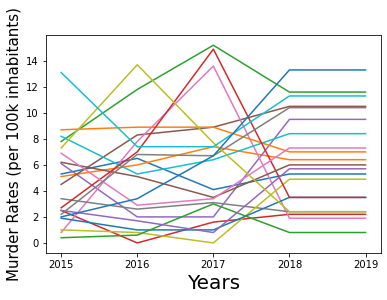

In [37]:
#lineplot showing the change in murder rates over 5 years in select cities

counter = 0
for items in rates_df3:
    if counter <= 20: 
        x = sns.lineplot(data = rates_df3, y = rates_df3.iloc[:,counter], x = 'Years')
        counter += 1
        
x.set_xlabel("Years", fontsize = 20)
x.set_ylabel("Murder Rates (per 100k inhabitants)", fontsize = 15)


Text(0, 0.5, 'Murder Rates (per 100k inhabitants)')

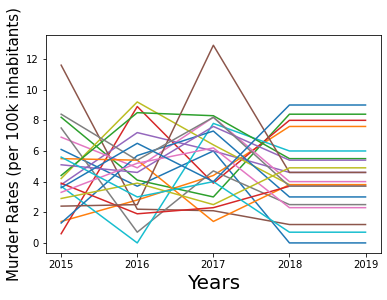

In [38]:
counter = 150
for items in rates_df3:
    if counter <= 170: 
        x = sns.lineplot(data = rates_df3, y = rates_df3.iloc[:,counter], x = 'Years')
        counter += 1
        
x.set_xlabel("Years", fontsize = 20)
x.set_ylabel("Murder Rates (per 100k inhabitants)", fontsize = 15)


Text(0, 0.5, 'Murder Rates (per 100k inhabitants)')

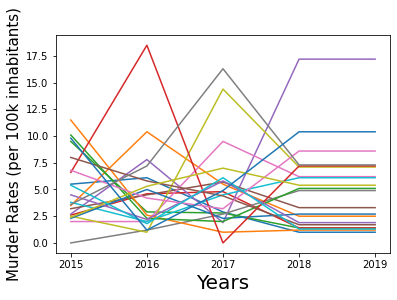

In [39]:
#lineplot showing the change in murder rates over 5 years in select cities

counter = 200
for items in rates_df3:
    if counter <= 220: 
        x = sns.lineplot(data = rates_df3, y = rates_df3.iloc[:,counter], x = 'Years')
        counter += 1
        
x.set_xlabel("Years", fontsize = 20)
x.set_ylabel("Murder Rates (per 100k inhabitants)", fontsize = 15)

There is generally no commonality between murder rate changes over the years in different cities. Some cities rate decreases and then increase and some increase and then decrease. Though, the rates stayed the same between the years 2018 and 2019. 

Murder Count for each year

6408
6938.0
7343.0
6502.0
5289.0


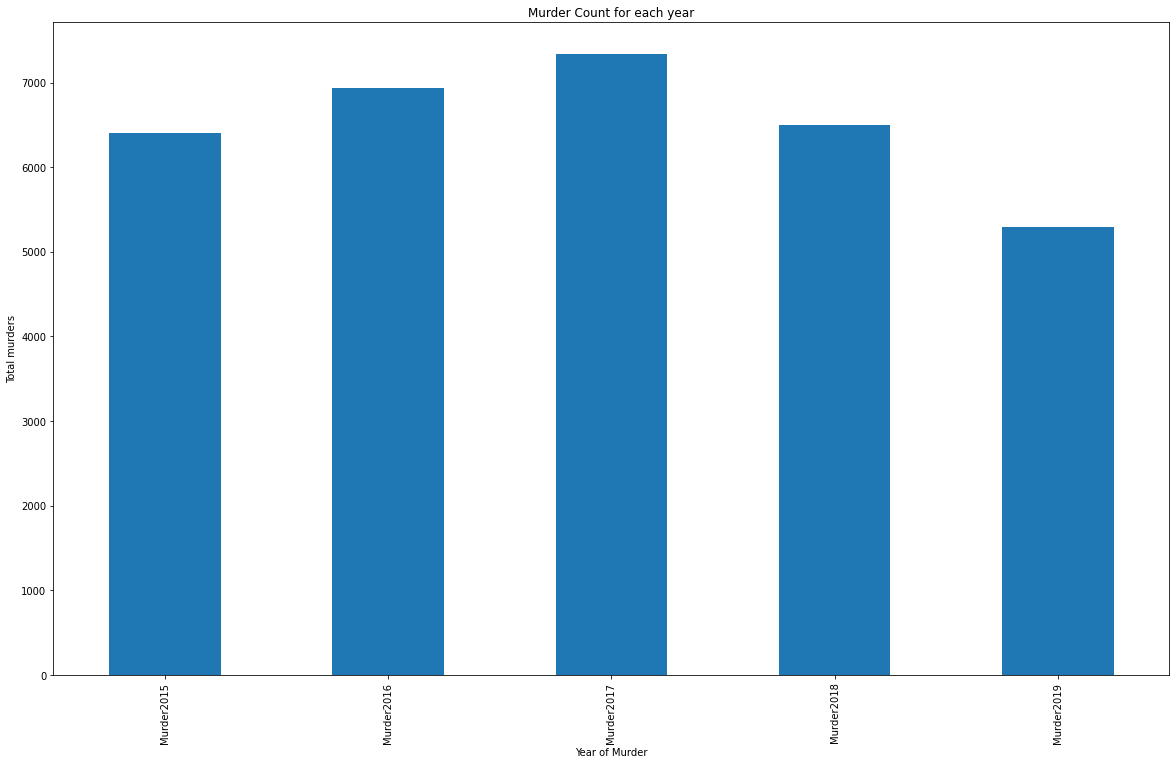

In [40]:
Murder2015 = citycombine['Murders 2015'].sum()
print(Murder2015)
Murder2016 = citycombine['Murders 2016'].sum()
print(Murder2016)
Murder2017 = citycombine['Murders 2017'].sum()
print(Murder2017)
Murder2018 = citycombine['Murders 2018'].sum()
print(Murder2018)
Murder2019 = citycombine['Murders 2019'].sum()
print(Murder2019)

total_murder_dict = {'Murder2015':Murder2015, 'Murder2016':Murder2016,'Murder2017':Murder2017,'Murder2018':Murder2018,'Murder2019':Murder2019}
total_murder_series = pd.Series(data=total_murder_dict)
total_murder_series.plot.bar(figsize = (20,12))

plt.title('Murder Count for each year')
plt.xlabel('Year of Murder')
plt.ylabel('Total murders')

plt.show()

We see that murder rates are the highest during 2017, and it is at its lowest in 2019, Lets see the criminal activity during both of these times.

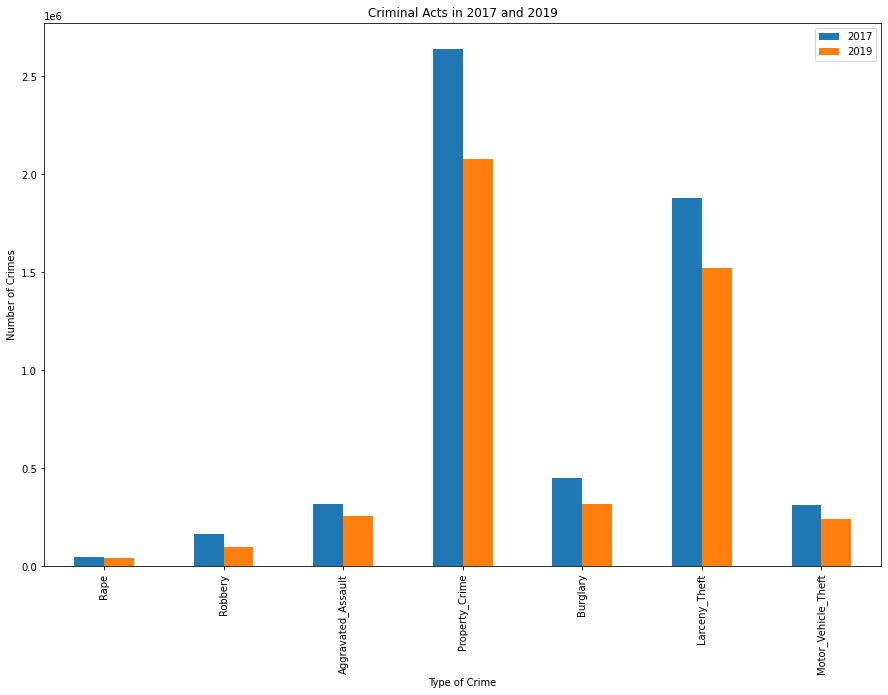

,2017,2019
Rape,47202.0,40367.0
Robbery,162474.0,99137.0
Aggravated_Assault,316698.0,254189.0
Property_Crime,2642138.0,2080885.0
Burglary,449875.0,319256.0
Larceny_Theft,1877821.0,1521189.0
Motor_Vehicle_Theft,314442.0,240440.0


In [41]:
criminal_acts2017 = []
for column in citycombine[['Rape 2017', 'Robbery 2017','Aggravated_Assault 2017', 'Property_Crime 2017', 'Burglary 2017','Larceny_Theft 2017', 'Motor_Vehicle_Theft 2017']]:
    criminal_acts2017.append(citycombine[column].sum())
    
#CA_ser2017 = pd.Series(data=criminal_acts2017, index=['Rape 2017', 'Robbery 2017','Aggravated_Assault 2017', 'Property_Crime 2017', 'Burglary 2017','Larceny_Theft 2017', 'Motor_Vehicle_Theft 2017'])

criminal_acts2019 = []
for column in citycombine[['Rape 2019', 'Robbery 2019','Aggravated_Assault 2019', 'Property_Crime 2019', 'Burglary 2019','Larceny_Theft 2019', 'Motor_Vehicle_Theft 2019']]:
    criminal_acts2019.append(citycombine[column].sum())
    
#CA_ser2017 = pd.Series(data=criminal_acts2017, index=['Rape 2017', 'Robbery 2017','Aggravated_Assault 2017', 'Property_Crime 2017', 'Burglary 2017','Larceny_Theft 2017', 'Motor_Vehicle_Theft 2017'])
Murder2017_2019df = pd.DataFrame({'2017':criminal_acts2017,
                                '2019':criminal_acts2019},index=['Rape', 'Robbery','Aggravated_Assault', 'Property_Crime', 'Burglary','Larceny_Theft', 'Motor_Vehicle_Theft'])
Murder2017_2019df.plot.bar(figsize = (15,10))

plt.title('Criminal Acts in 2017 and 2019')
plt.xlabel('Type of Crime')
plt.ylabel('Number of Crimes')

plt.show()
Murder2017_2019df

We can see from the graph that there was an overall increase of criminal activity in 2017 compared to 2019. However, since some criminal acts are more common than others, it would be valuable to see a percentage increase on criminal activity rather than just the numbers.

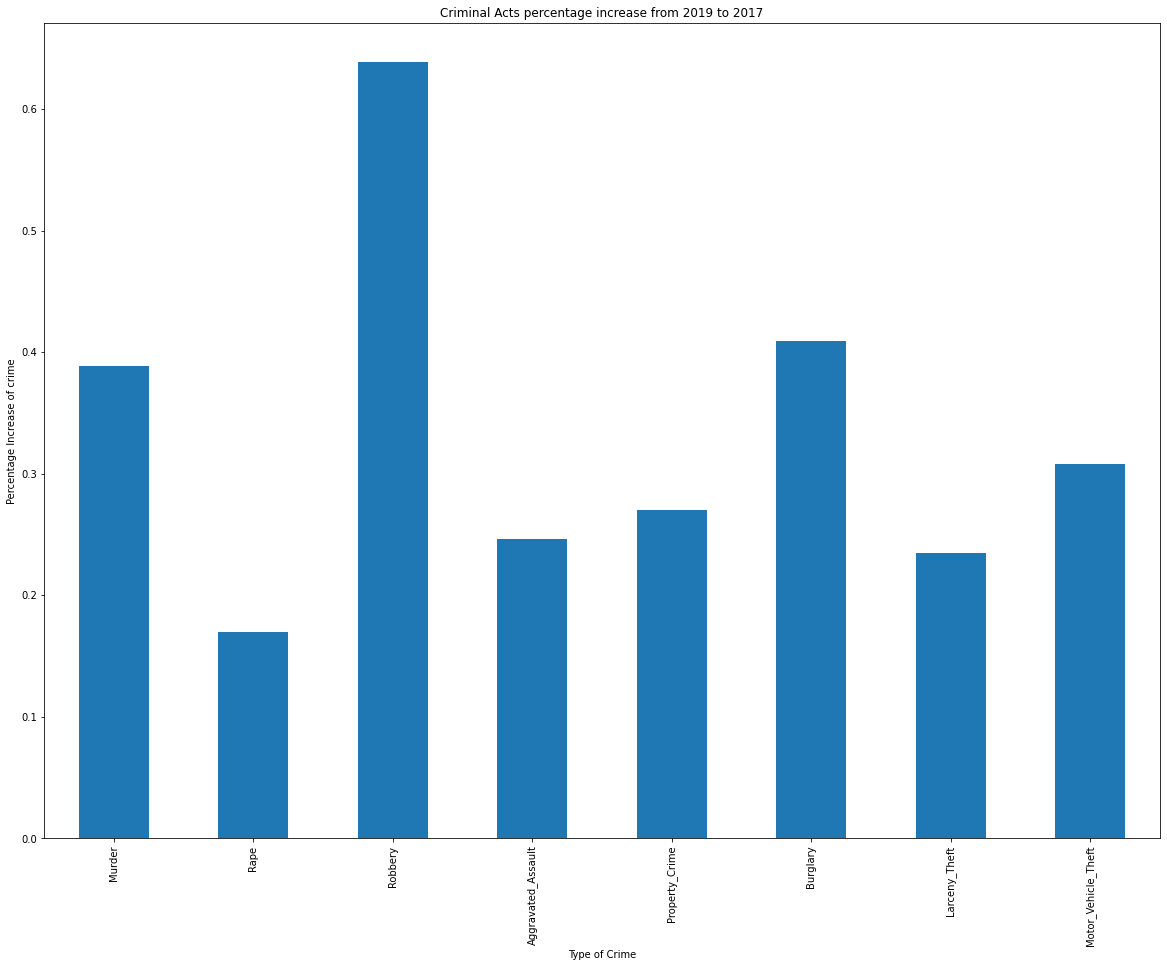

In [42]:
percent_inc2017_2019 = []
percent_inc2017_2019.append(Murder2017/Murder2019-1)
for i in Murder2017_2019df.index:
    percent_inc2017_2019.append(Murder2017_2019df.loc[i,'2017']/Murder2017_2019df.loc[i,'2019'] -1)
percent_inc2017_2019_ser = pd.Series(data = percent_inc2017_2019, index = ['Murder','Rape', 'Robbery','Aggravated_Assault', 'Property_Crime', 'Burglary','Larceny_Theft', 'Motor_Vehicle_Theft'])

percent_inc2017_2019_ser.plot.bar(figsize = (20,15))

plt.title('Criminal Acts percentage increase from 2019 to 2017')
plt.xlabel('Type of Crime')
plt.ylabel('Percentage Increase of crime')

plt.show()


Now we can see that the number of robberies in 2017 compared to 2019 increased the most. Now that we know this, lets compare the amount of roberies per year from 2015 to 2019 to murders.

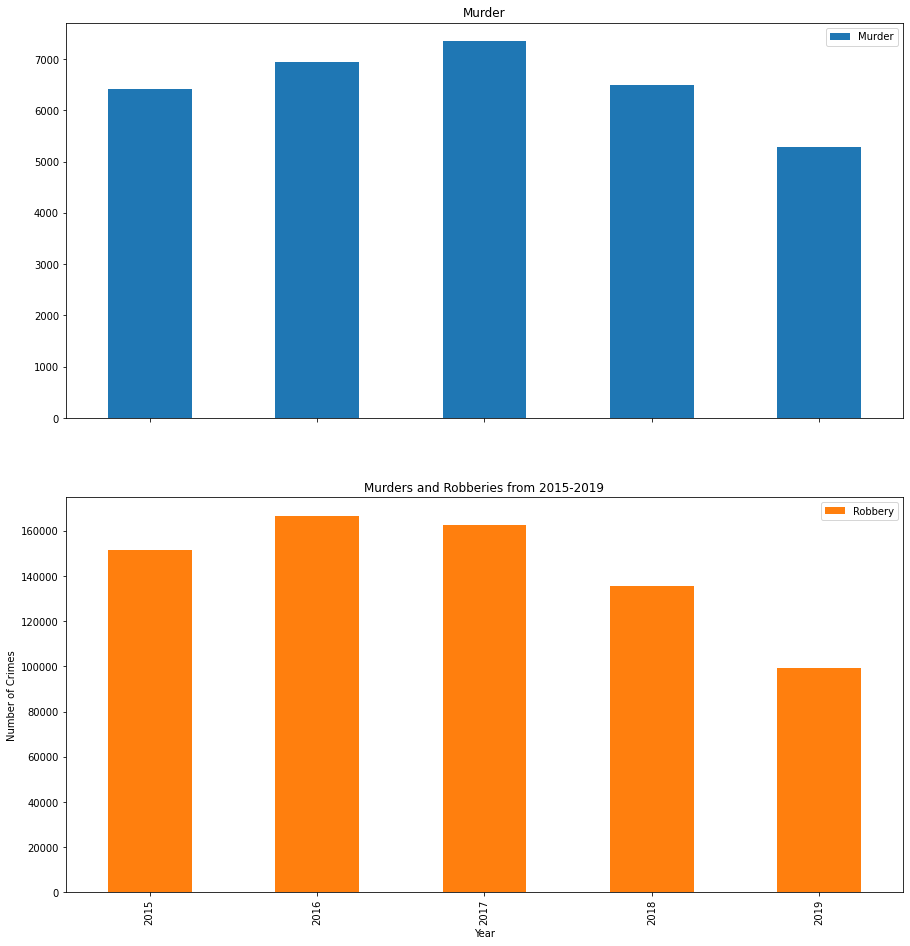

In [43]:
total_robbery_arr = []
Robbery2015 = citycombine['Robbery 2015'].sum()
total_robbery_arr.append(Robbery2015)
#print(Robbery2015)
Robbery2016 = citycombine['Robbery 2016'].sum()
total_robbery_arr.append(Robbery2016)
#print(Robbery2016)
Robbery2017 = citycombine['Robbery 2017'].sum()
total_robbery_arr.append(Robbery2017)
#print(Robbery2017)
Robbery2018 = citycombine['Robbery 2018'].sum()
total_robbery_arr.append(Robbery2018)
#print(Robbery2018)
Robbery2019 = citycombine['Robbery 2019'].sum()
total_robbery_arr.append(Robbery2019)
#print(Robbery2019)

total_robbery_series = pd.Series(data=total_robbery_arr, index= ['Robbery2015','Robbery2016','Robbery2017','Robbery2018','Robbery2019'])

Murder_Robberydf = pd.DataFrame({'Murder':list(total_murder_dict.values()),
                                'Robbery':total_robbery_arr},index=['2015','2016','2017','2018','2019'])

Murder_Robberydf.plot.bar(subplots=True, figsize = (15,16))

plt.title('Murders and Robberies from 2015-2019')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')

plt.show()


We can see that the shape of murders and Robberies are very similar. Lets see if this is shown for the other crimes.

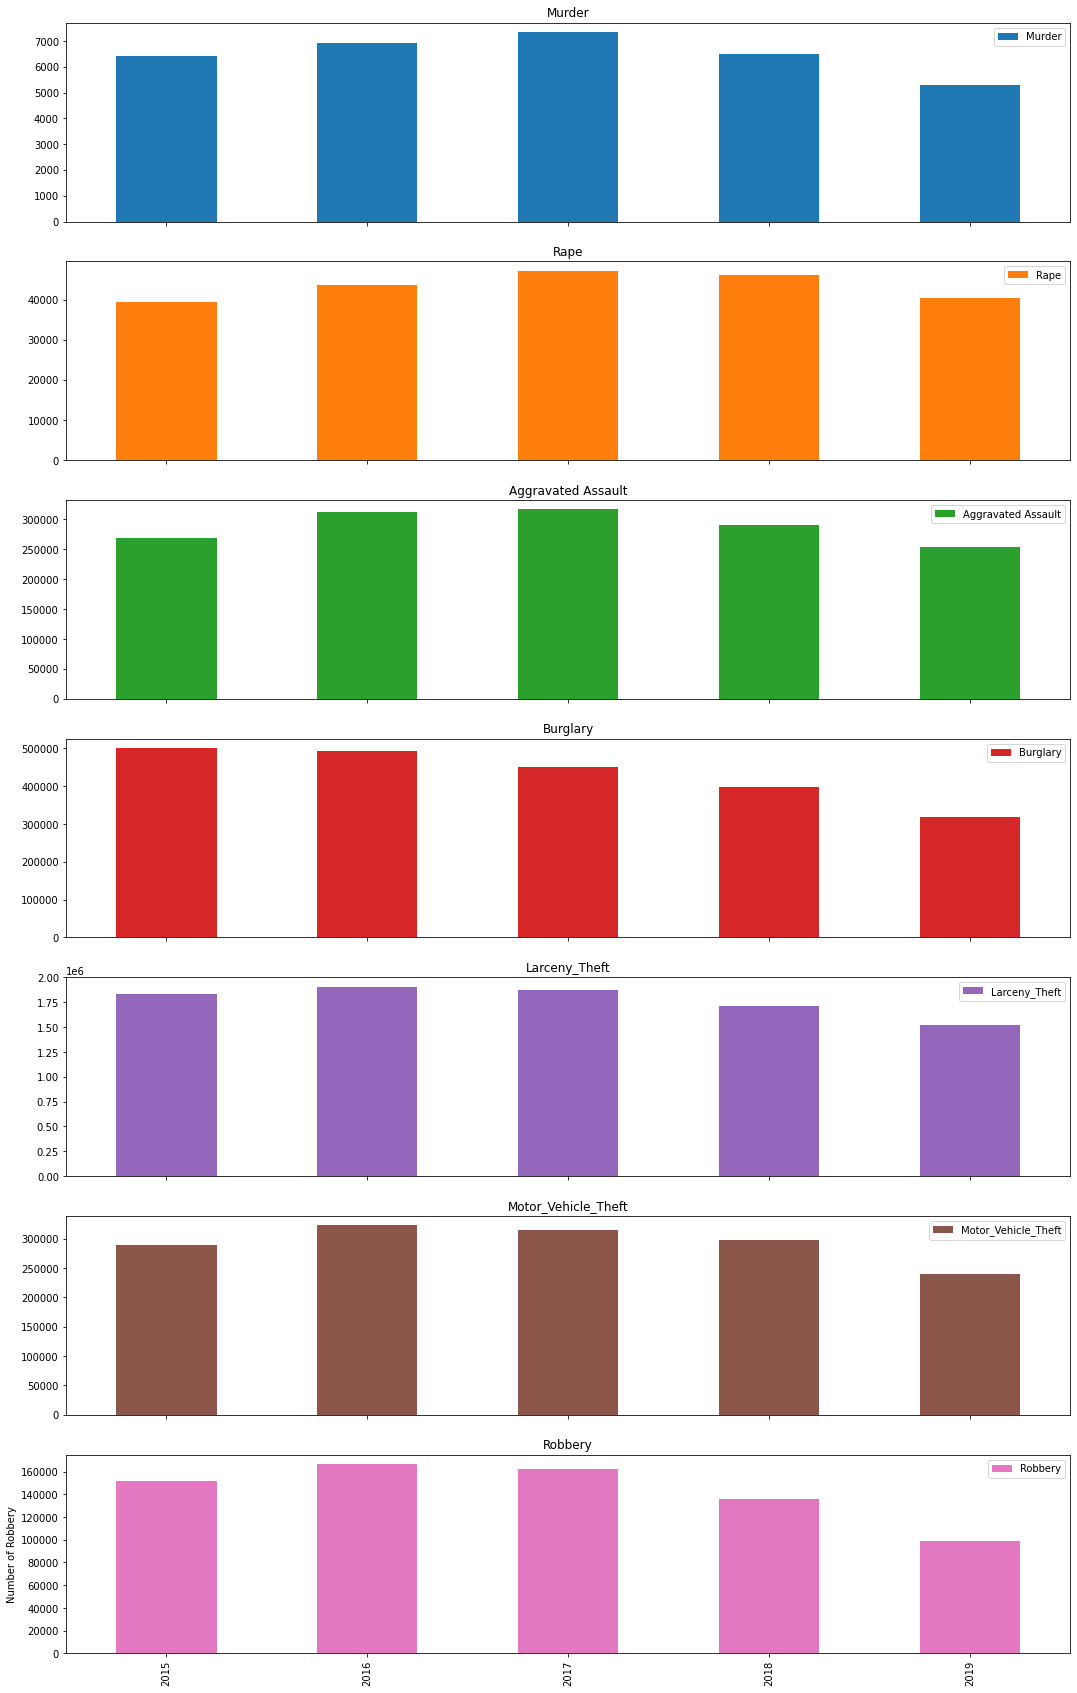

In [44]:
rape_arr = citycombine[['Rape 2015','Rape 2016','Rape 2017','Rape 2018','Rape 2019']].sum().tolist()
assault_arr = citycombine[['Aggravated_Assault 2015','Aggravated_Assault 2016','Aggravated_Assault 2017','Aggravated_Assault 2018','Aggravated_Assault 2019']].sum().tolist()
property_Crime_arr = citycombine[['Property_Crime 2015','Property_Crime 2016','Property_Crime 2017','Property_Crime 2018','Property_Crime 2019']].sum().tolist()
burglary_arr = citycombine[['Burglary 2015','Burglary 2016','Burglary 2017','Burglary 2018','Burglary 2019']].sum().tolist()
larceny_Theft_arr = citycombine[['Larceny_Theft 2015','Larceny_Theft 2016','Larceny_Theft 2017','Larceny_Theft 2018','Larceny_Theft 2019']].sum().tolist()
motor_Vehicle_Theft_arr = citycombine[['Motor_Vehicle_Theft 2015','Motor_Vehicle_Theft 2016','Motor_Vehicle_Theft 2017','Motor_Vehicle_Theft 2018','Motor_Vehicle_Theft 2019']].sum().tolist()

Total_Crimes_df = pd.DataFrame({'Murder':list(total_murder_dict.values()),
                                'Rape': rape_arr,
                                'Aggravated Assault' : assault_arr,
                                'Burglary': burglary_arr,
                                'Larceny_Theft' : larceny_Theft_arr,
                                'Motor_Vehicle_Theft' : motor_Vehicle_Theft_arr,
                                'Robbery':total_robbery_arr},
                                index=['2015','2016','2017','2018','2019'])

Total_Crimes_df.plot.bar(subplots=True,figsize = (18,30))
#plt.figure(figsize = (10,1))
plt.ylabel('Number of Robbery')
plt.show()

In [45]:
#outcome, predictors = patsy.dmatrices('"Robbery 2017" ~ "Murders 2017"', citycombine)
#mod = sm.OLS(outcome, predictors)
#res = mod.fit()
#print(res.summary())
# print(citycombine['Murders 2017'].astype('int').corr(citycombine['Robbery 2017']))

In [46]:
print("Total Rape and Murder correlation")
print(Total_Crimes_df['Murder'].corr(Total_Crimes_df['Rape']))
print("Total Burglary and Murder correlation")
print(Total_Crimes_df['Murder'].corr(Total_Crimes_df['Burglary']))
print("Total Aggravated Assault and Murder correlation")
print(Total_Crimes_df['Murder'].corr(Total_Crimes_df['Aggravated Assault']))
print("Total Larceny Theft and Murder correlation")
print(Total_Crimes_df['Murder'].corr(Total_Crimes_df['Larceny_Theft']))
print("Total Motor Vehicle Theft and Murder correlation")
print(Total_Crimes_df['Murder'].corr(Total_Crimes_df['Motor_Vehicle_Theft']))
print("Total Robbery and Murder correlation")
print(Total_Crimes_df['Murder'].corr(Total_Crimes_df['Robbery']))


Total Rape and Murder correlation
0.698684588934467
Total Burglary and Murder correlation
0.7413694005906131
Total Aggravated Assault and Murder correlation
0.9343379379924214
Total Larceny Theft and Murder correlation
0.9159777784759447
Total Motor Vehicle Theft and Murder correlation
0.9590348567941476
Total Robbery and Murder correlation
0.9381802146494735
